**Predict cuisine type from recipe ingedients**

*Step 1: Import Python Packages*

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
import graphviz 
import json
import time
import gc
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from collections import Counter
from sklearn import model_selection
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import networkx as nx
import warnings
%matplotlib inline
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
notebookstart= time.time()

*Step 2: Exploratory Data Analysis*

In [2]:
train_df = pd.read_json('../input/train.json')
test_df = pd.read_json('../input/test.json')
train=train_df
train.head(15)

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli..."
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo..."
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por..."
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-..."


In [3]:
train=train_df
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total missing', 'Percent missing'])
print("             # of Rows, Columns:",train.shape)
print(missing_train_data.head())

             # of Rows, Columns: (39774, 3)
             Total missing  Percent missing
ingredients              0              0.0
id                       0              0.0
cuisine                  0              0.0


In [4]:
# adapted from https://www.kaggle.com/ashishpatel26/scrumptious-cooking-foods
color_theme = dict(color = ['rgba(221,160,221,1)','rgba(169,169,169,1)','rgba(255,160,122,1)','rgba(176,224,230,1)','rgba(169,169,169,1)','rgba(255,160,122,1)','rgba(176,224,230,1)',
                   'rgba(188,143,143,1)','rgba(221,160,221,1)','rgba(169,169,169,1)','rgba(255,160,122,1)','rgba(176,224,230,1)','rgba(189,183,107,1)','rgba(188,143,143,1)','rgba(221,160,221,1)','rgba(169,169,169,1)','rgba(255,160,122,1)','rgba(176,224,230,1)','rgba(169,169,169,1)','rgba(255,160,122,1)'])
temp = train['cuisine'].value_counts()
trace = go.Bar(y=temp.index[::-1],x=(temp)[::-1],orientation = 'h',marker=color_theme)
layout = go.Layout(title = "Count of recipes per cuisine",xaxis=dict(title='Recipe count',tickfont=dict(size=14,)),
                   yaxis=dict(title='Cuisine',titlefont=dict(size=16),tickfont=dict(size=14)),margin=dict(l=200,))
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig,filename='basic-bar')

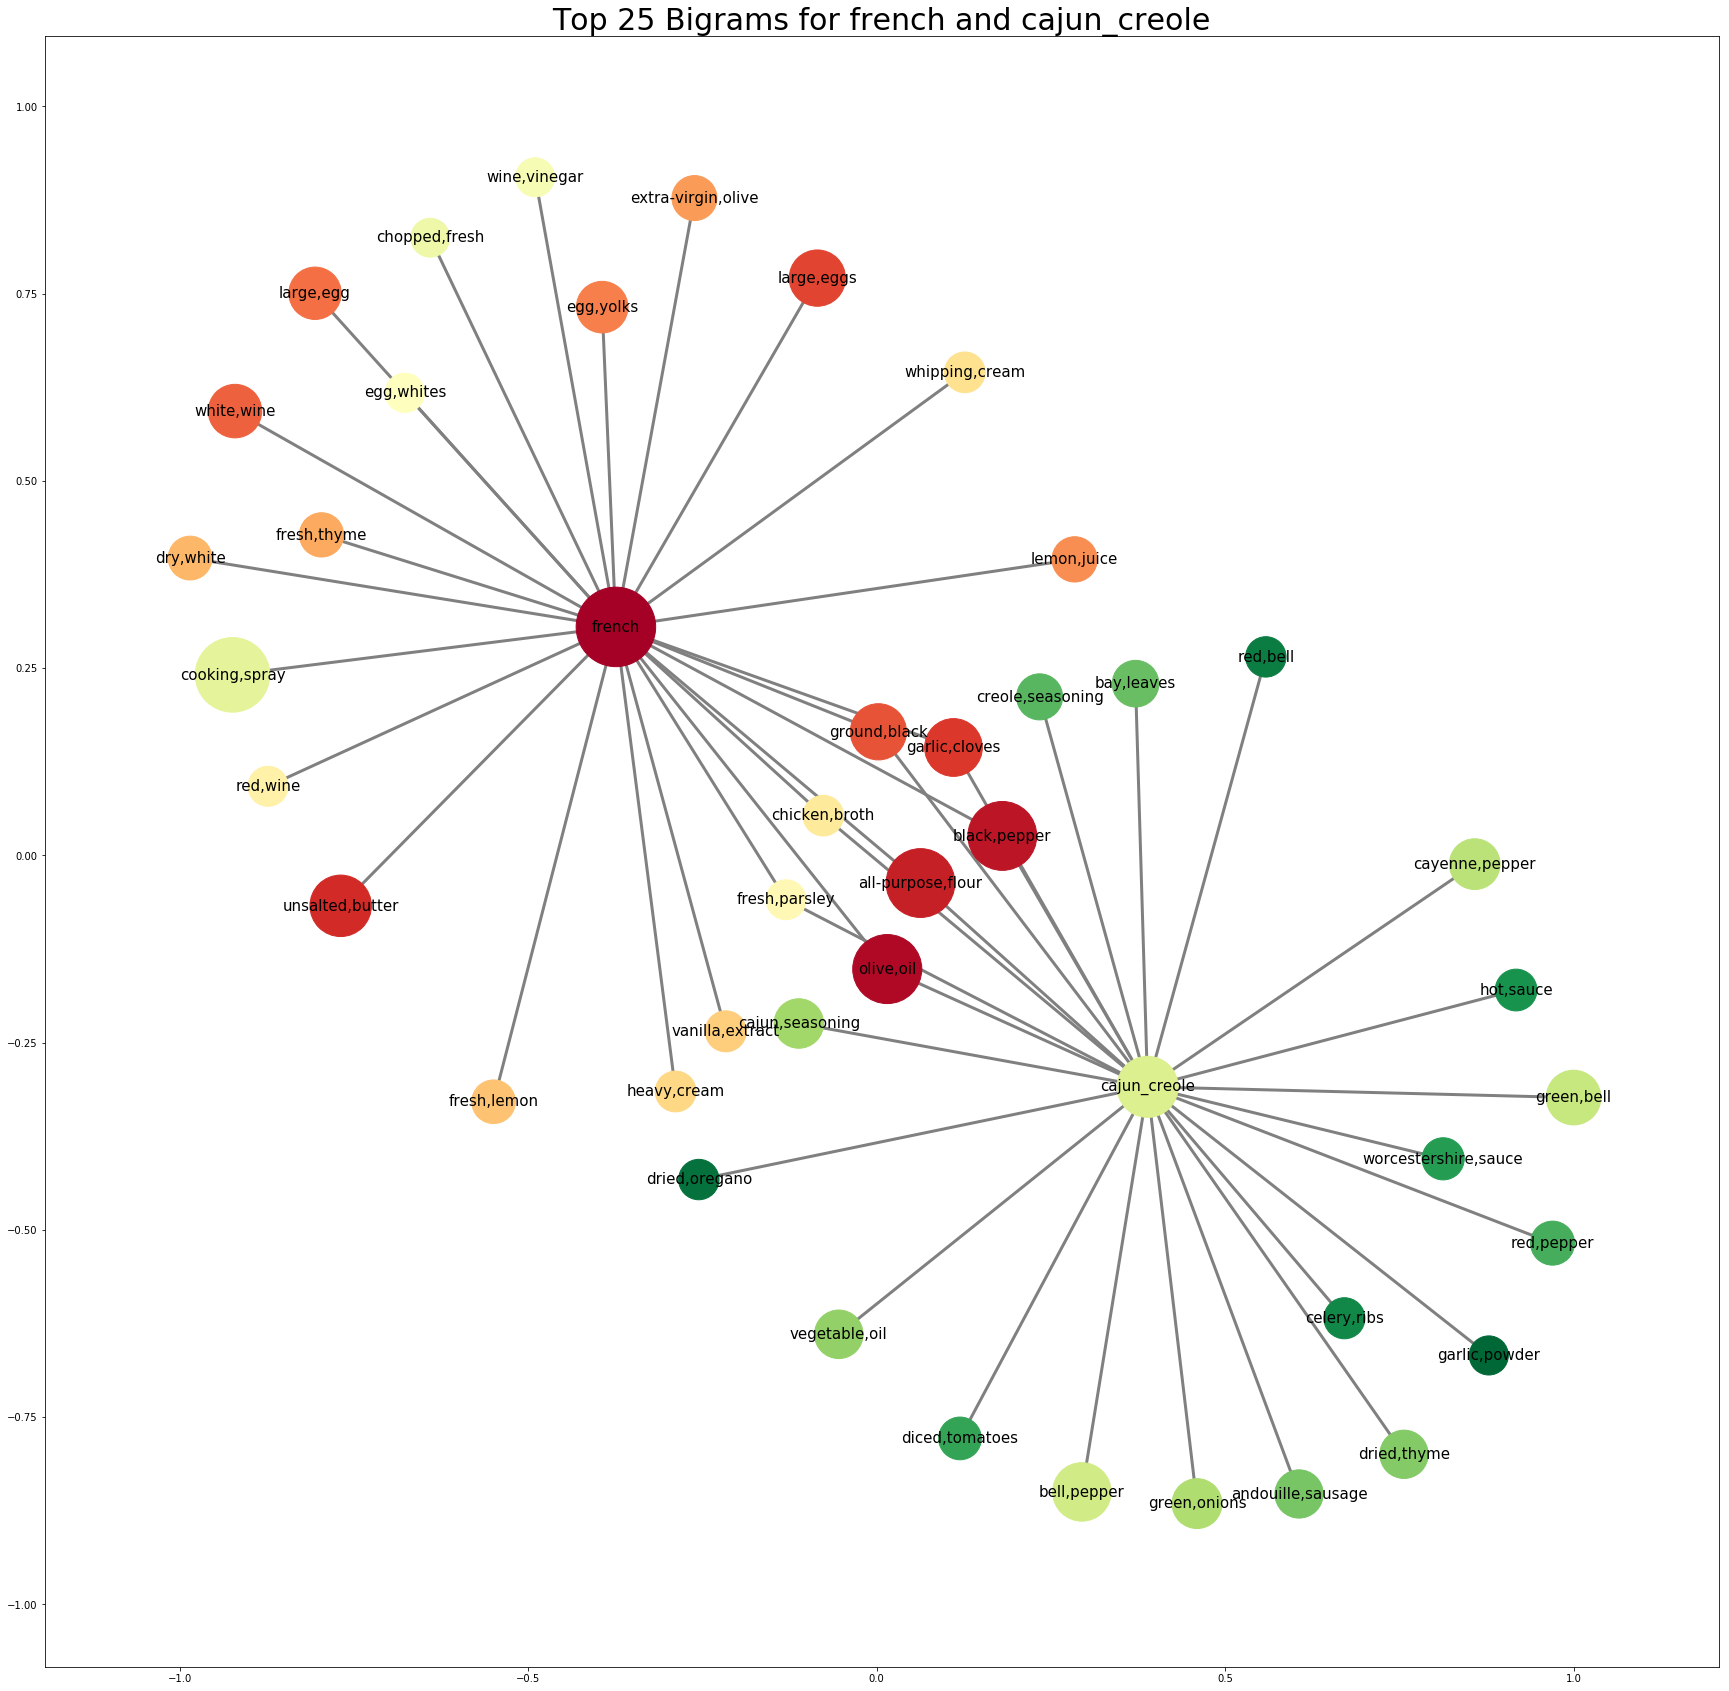

In [5]:
# adapted from https://www.kaggle.com/ash316/what-is-the-rock-cooking-ensembling-network
train_df['seperated_ingredients'] = train_df['ingredients'].apply(','.join)
test_df['seperated_ingredients'] = test_df['ingredients'].apply(','.join)
train_df['for ngrams']=train_df['seperated_ingredients'].str.replace(',',' ')
def generate_ngrams(text, n):
    words = text.split(' ')
    iterations = len(words) - n + 1
    for i in range(iterations):
       yield words[i:i + n]
def net_diagram(*cuisines):
    ngrams = {}
    for title in train_df[train_df.cuisine==cuisines[0]]['for ngrams']:
            for ngram in generate_ngrams(title, 2):
                ngram = ','.join(ngram)
                if ngram in ngrams:
                    ngrams[ngram] += 1
                else:
                    ngrams[ngram] = 1

    ngrams_mws_df = pd.DataFrame.from_dict(ngrams, orient='index')
    ngrams_mws_df.columns = ['count']
    ngrams_mws_df['cusine'] = cuisines[0]
    ngrams_mws_df.reset_index(level=0, inplace=True)

    ngrams = {}
    for title in train_df[train_df.cuisine==cuisines[1]]['for ngrams']:
            for ngram in generate_ngrams(title, 2):
                ngram = ','.join(ngram)
                if ngram in ngrams:
                    ngrams[ngram] += 1
                else:
                    ngrams[ngram] = 1

    ngrams_mws_df1 = pd.DataFrame.from_dict(ngrams, orient='index')
    ngrams_mws_df1.columns = ['count']
    ngrams_mws_df1['cusine'] = cuisines[1]
    ngrams_mws_df1.reset_index(level=0, inplace=True)
    cuisine1=ngrams_mws_df.sort_values('count',ascending=False)[:25]
    cuisine2=ngrams_mws_df1.sort_values('count',ascending=False)[:25]
    df_final=pd.concat([cuisine1,cuisine2])
    g = nx.from_pandas_dataframe(df_final,source='cusine',target='index')
    cmap = plt.cm.RdYlGn
    colors = [n for n in range(len(g.nodes()))]
    k = 0.35
    pos=nx.spring_layout(g, k=k)
    nx.draw_networkx(g,pos, node_size=df_final['count'].values*8, cmap = cmap, node_color=colors, edge_color='grey', font_size=15, width=3)
    plt.title("Top 25 Bigrams for %s and %s" %(cuisines[0],cuisines[1]), fontsize=30)
    plt.gcf().set_size_inches(30,30)
    plt.show()
    plt.savefig('network.png')
net_diagram('french','cajun_creole')

*Step 3: Feature Engineering*

* Method 1 of 2: [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [6]:
# adapted from https://www.kaggle.com/nicapotato/this-model-is-bland-simple-logistic-starter
df = pd.read_json('../input/train.json').set_index('id')
test_df = pd.read_json('../input/test.json').set_index('id')
traindex = df.index
testdex = test_df.index
y = df.cuisine.copy()
df = pd.concat([df.drop("cuisine", axis=1), test_df], axis=0)
df_index = df.index
del test_df; gc.collect();
vect = CountVectorizer()
dummies = vect.fit_transform(df.ingredients.str.join(' '))
df = pd.DataFrame(dummies.todense(),columns=vect.get_feature_names())
df.index= df_index
X = df.loc[traindex,:]
test_df = df.loc[testdex,:]
del df; gc.collect();

* Method 2 of 2: [TfidVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [7]:
# adapted from https://www.kaggle.com/shivamb/what-s-cooking-tf-idf-with-ovr-svm
def read_dataset(path):
    return json.load(open(path)) 
train = read_dataset('../input/train.json')
test = read_dataset('../input/test.json')
def generate_text(data):
    text_data = [" ".join(doc['ingredients']).lower() for doc in data]
    return text_data 
train_text = generate_text(train)
test_text = generate_text(test)
target = [doc['cuisine'] for doc in train]
tfidf = TfidfVectorizer(binary=True)
def tfidf_features(txt, flag):
    if flag == "train":
        x = tfidf.fit_transform(txt)
    else:
        x = tfidf.transform(txt)
    x = x.astype('float16')
    return x 
X2 = tfidf_features(train_text, flag="train")
X_test3 = tfidf_features(test_text, flag="test")
lb = LabelEncoder()
y2 = lb.fit_transform(target)

*Step 4: Evaluate ML Models*

In [8]:
# adapted from https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
def compareAccuracy(a, b): 
    print('\nCompare Multiple Classifiers: \n')
    print('K-Fold Cross-Validation Accuracy: \n')
    names = []
    models = []
    resultsAccuracy = []
    models.append(('LR', LogisticRegression()))
    models.append(('LSVM', LinearSVC()))
    models.append(('RF', RandomForestClassifier()))
    for name, model in models:
        model.fit(a, b)
        kfold = model_selection.KFold(n_splits=10, random_state=7)
        accuracy_results = model_selection.cross_val_score(model, a,b, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage) 
    # Boxplot
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()    
      
def defineModels():
    print('\nLR = LogisticRegression')
    print('LSVM = LinearSVM')
    print('RF = RandomForestClassifier')

Evaluate Method 1 of 2 ([CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)) with Logistic Regression, Linear SVM, and Random Forest models.


Compare Multiple Classifiers: 

K-Fold Cross-Validation Accuracy: 

LR: 0.788128 (0.006075)
LSVM: 0.779730 (0.005160)
RF: 0.710137 (0.008363)


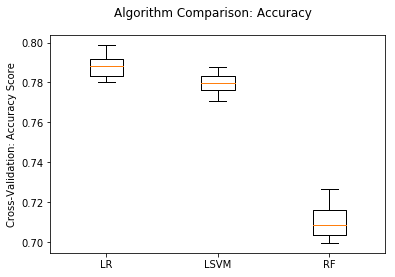


LR = LogisticRegression
LSVM = LinearSVM
RF = RandomForestClassifier


In [9]:
compareAccuracy(X,y)
defineModels()

Evaluate Method 2 of 2 ([TfidVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)) with Logistic Regression, Linear SVM, and Random Forest models.



Compare Multiple Classifiers: 

K-Fold Cross-Validation Accuracy: 

LR: 0.780334 (0.004966)
LSVM: 0.792276 (0.005597)
RF: 0.695907 (0.005199)


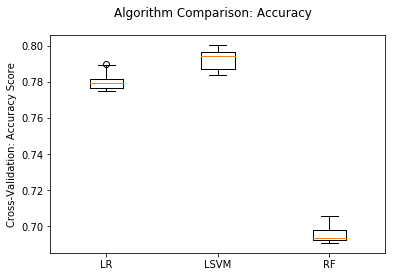


LR = LogisticRegression
LSVM = LinearSVM
RF = RandomForestClassifier


In [10]:
compareAccuracy(X2,y2)
defineModels()

*Step 5: Submit Results*

For submission we will use an approach that uses [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)() for engineering features and [LinearSVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)() for making predictions. 

In [11]:
model = LinearSVC()
model.fit(X, y)
submission = model.predict(test_df)
submission_df = pd.Series(submission, index=testdex).rename('cuisine')
submission_df.to_csv("recipe_submission.csv", index=True, header=True)
model.fit(X2, y2)
y_test3 = model.predict(X_test3)
y_pred = lb.inverse_transform(y_test3)
test_id = [doc['id'] for doc in test]
sub = pd.DataFrame({'id': test_id, 'cuisine': y_pred}, columns=['id', 'cuisine'])
sub.to_csv('recipe_submission2.csv', index=False)